In [1]:
import pathlib
import os

# Create file structure

Same as before, but we will store the bigger dataset in a separate folder because I want to keep my sample for consistency.

In [2]:
p = pathlib.Path('.')

In [3]:
for c in ['vegan', 'not_vegan']:
        os.makedirs(p/'big_data'/c, exist_ok=True)

data_dir = p/'big_data'

In [4]:
ls = lambda x : list(x.iterdir())

ls(p/'big_data')

[PosixPath('big_data/not_vegan'), PosixPath('big_data/vegan')]

# Scrape Instragram

Same as before, but this time we try to scrape as much as 5000 media per account to create a bigger dataset.

In [5]:
vegan_food_accounts     = "buddha_bowls,vegan_bowls,vegansrecipe,thevegansclub,thevegansclublifestyle,thefeedfeed.vegan".split(',')

not_vegan_food_accounts = "burgersofthedays,sushiporn,foodgawker,ks_ate_here,thefeedfeed,huttoneats".split(',')

In [5]:
vegan_dir = data_dir.absolute()/'vegan'
not_vegan_dir = data_dir.absolute()/'not_vegan'

### Scraping images from food accounts

In [ ]:
ds_length = 30000
max_scrap = int(ds_length / len(vegan_food_accounts))

print(f'Scraping {max_scrap} for each of the {len(vegan_food_accounts)} accounts.')
for username in vegan_food_accounts:
    !instagram-scraper @insta_args.txt {username} -t image -m {max_scrap} -d {vegan_dir}


In [ ]:
ds_length = 30000
max_scrap = int(ds_length / len(not_vegan_food_accounts))

print(f'Scraping {max_scrap} for each of the {len(not_vegan_food_accounts)} accounts.')
for username in not_vegan_food_accounts:
    !instagram-scraper @insta_args.txt {username} -t image -m {max_scrap} -d {not_vegan_dir}

### Removing videos from the pictures

In [8]:
is_a_video = lambda path : '.mp4' in str(path)
for each_dir in [vegan_dir, not_vegan_dir]:
    for each_file in each_dir.iterdir():
        if is_a_video(each_file):
            each_file.unlink()

# Train a classifier

In [6]:
from fastai.vision import *

In [7]:
from fastai import *

In [8]:
verify_images(path=vegan_dir)

In [9]:
verify_images(path=not_vegan_dir)

In [10]:
data = ImageDataBunch.from_folder(p, train='big_data', valid_pct=0.2, size=224, ds_tfms=get_transforms()).normalize(imagenet_stats)

Let's see how many images we gathered in our bigger dataset.

In [45]:
count_files = lambda folder : len(list(folder.iterdir()))

n_veg = count_files(vegan_dir)
n_not = count_files(not_vegan_dir)
total = n_not+n_veg

print(f'Number of vegan images :  {n_veg}    {n_veg/total:.0%}')
print(f'Else                   : {n_not}    {n_not/total:.0%}')
print('-'*30)
print(f'TOTAL =                : {total}   {total/total:.0%}')

print(f'\nValidation set is 20% so  {int(total*0.2)} images')


Number of vegan images :  6771    32%
Else                   : 14364    68%
------------------------------
TOTAL =                : 21135   100%

Validation set is 20% so  4227 images


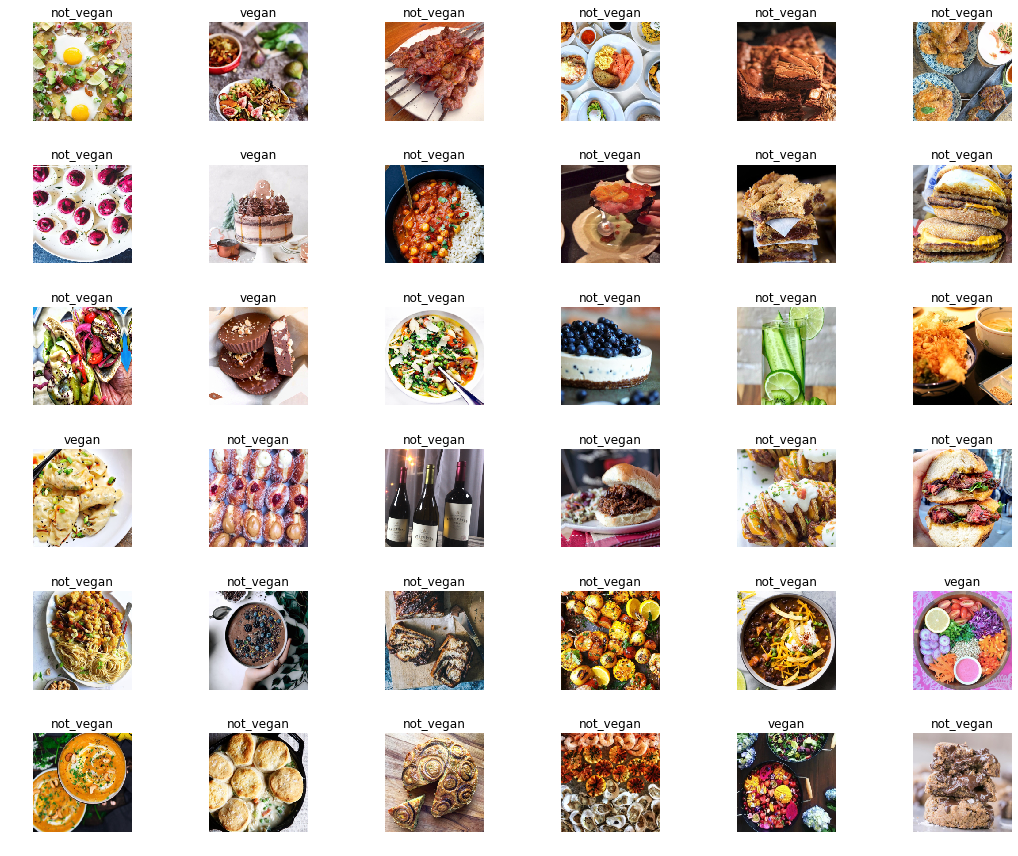

In [25]:
data.show_batch(rows=6, figsize=(15,12))

We can see some examples are clearly mislabelled (e.g. cucumber and lime drink) or have nothing to do here (e.g wine). But it's ok, we will take note of this flaw and proceed nonetheless.

### Training of a CNN classifier

In [11]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


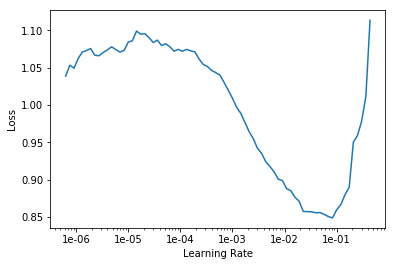

In [51]:
learn.lr_find()
learn.recorder.plot()

Based on the results from the learning rate finder, I decide to use a range starting from 0.03 down to 0.001 for the learning rate.

I train for 8 epochs and will see what to do next then.

In [52]:
learn.fit_one_cycle(8, max_lr=slice(1e-3, 3e-2))
learn.save('frozen-8epochs')

epoch,train_loss,valid_loss,error_rate
1,0.428380,0.419848,0.179684
2,0.398995,0.398301,0.164110
3,0.386739,0.391472,0.181311
4,0.363790,0.409051,0.181079
5,0.343056,0.342522,0.152952
6,0.310813,0.323789,0.143422
7,0.293852,0.311395,0.139702
8,0.282039,0.317187,0.145049


I am gonna try to make it go down a bit more.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


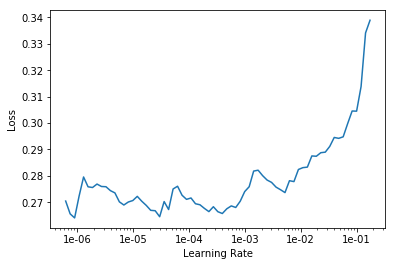

In [53]:
learn.lr_find()
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(8, max_lr=slice(5e-5, 5e-4))
learn.save('frozen-16epochs')

epoch,train_loss,valid_loss,error_rate
1,0.281304,0.314415,0.138773
2,0.268765,0.315576,0.142259
3,0.281579,0.310524,0.139238
4,0.268951,0.311955,0.138308
5,0.266655,0.313287,0.140865
6,0.267266,0.310768,0.136216
7,0.273818,0.310174,0.137146
8,0.272218,0.311965,0.139470


Well, it has plateaued, maybe my max learning rate for this cycle was not high enough to shock the network.

### Interlude: I play around with some methods I don't know about

Let's what it has found.

In [57]:
learn.interpret()

In [58]:
interpr = _
interpr

__LIFE SAVING TIPS__: I was exploring the available methods using autocompletion features and found the interpret one. 

So I decided to give it a go. 

It happened to take quite some time and when it was finish I realised it was actually returning an object, which I hadn't assigned.

I didn't want to re-run it so I used a trick, in an interactive shell you can get access to the last results printed by using `_`.

This trick saved a good ten minutes of my life, and will surely save more.

More info [here. (stack overflow)](https://stackoverflow.com/questions/200020/get-last-result-in-interactive-python-shell)

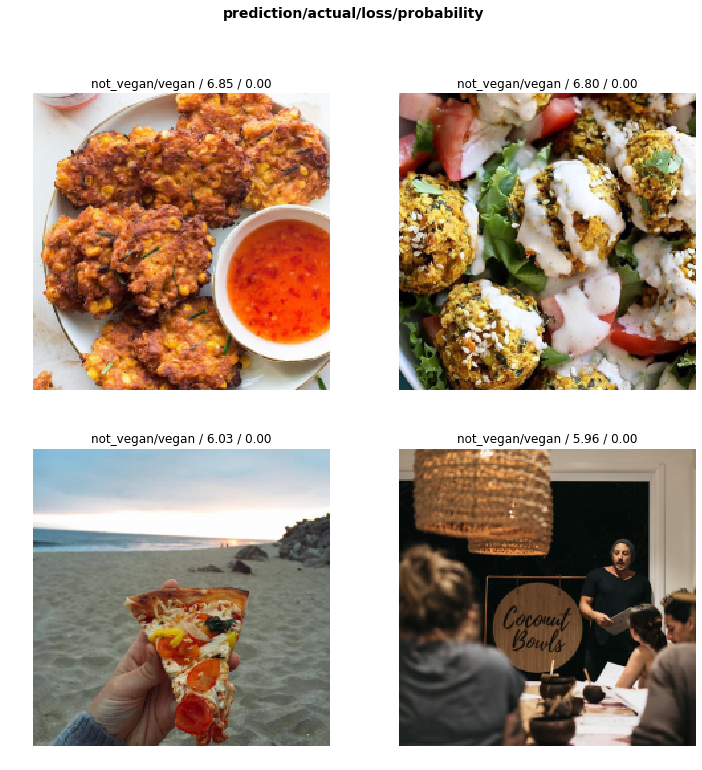

In [69]:
interpr.plot_top_losses(k=4)

Well, I wouldn't have found it either... Can you really believe all these dishes are vegan?

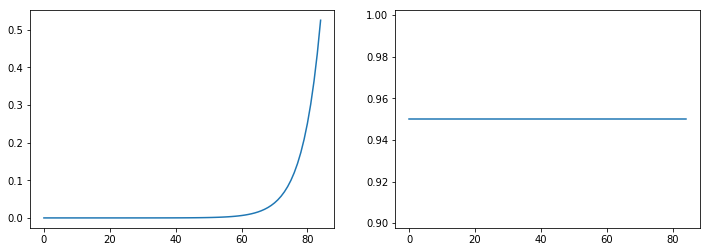

In [75]:
learn.recorder.plot_lr(show_moms=True)

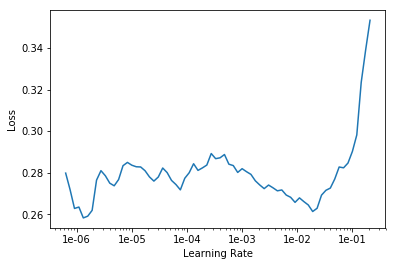

In [76]:
learn.recorder.plot()

### Interlude comes to an end, let's get back to training


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


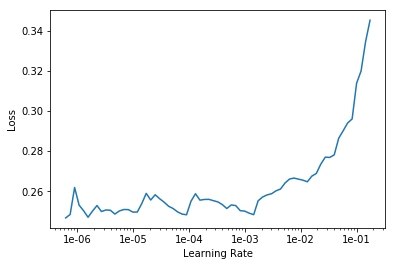

In [77]:
learn.lr_find()
learn.recorder.plot()

We will use a small learning rate to finetune the network a bit further.

In [78]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))
learn.save('frozen-18epochs')

epoch,train_loss,valid_loss,error_rate
1,0.263152,0.311081,0.136913
2,0.265961,0.311360,0.139005


Maybe it wasn't necessary. Let's unfreeze.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


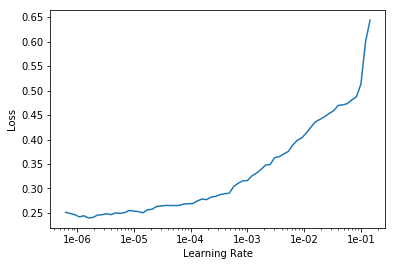

In [79]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

This time I will stick to the smallest sensible learning rate to fine tune the ealier layers.

In [12]:
learn.load('frozen-18epochs');
learn.fit_one_cycle(4, max_lr=1e-6)
learn.save('unfrozen-18_4epochs')

epoch,train_loss,valid_loss,error_rate
1,0.278415,0.257486,0.120177
2,0.290683,0.257473,0.120177
3,0.269994,0.256806,0.119479
4,0.286939,0.256720,0.118782


Well that works, we earned almost 2 percent in the error rate. And we dropped down both loss of .10.

Can we push it further?

In [13]:
learn.fit_one_cycle(4, max_lr=1e-6)
learn.save('unfrozen-18_8epochs')

epoch,train_loss,valid_loss,error_rate
1,0.287834,0.259481,0.122269
2,0.275725,0.256570,0.118550
3,0.283595,0.256705,0.119479
4,0.276448,0.258032,0.121106


Ok let's just use the weights as they were just before this attempt. I am glad I saved the weights.

# Results and comparison Frozen & Unfrozen

## Unfrozen

In [29]:
learn.load('unfrozen-18_4epochs');
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

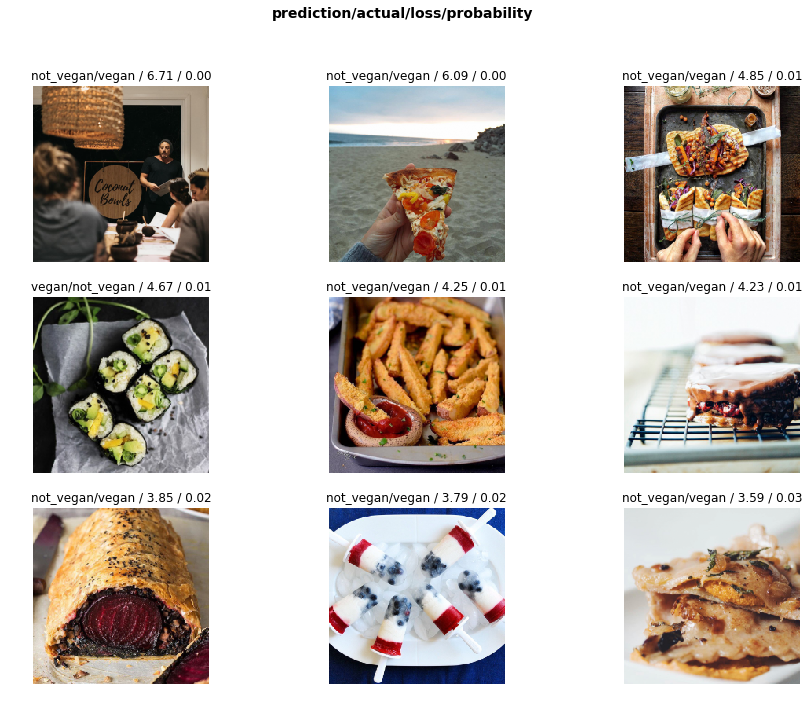

In [30]:
interp.plot_top_losses(9, figsize=(15,11))

It seems to associate sushi, Fries, pizzas and ice cream to not vegan food. Actually those dishes are made by vegan chef to look (and taste) like the real thing so it looks like acceptable mistakes to me.

A 10% error rate seems sensible without diving into the errors yet. Some things that are worth keeping in mind:

- Not-vegan accounts can feature vegan dishes as it is not mutually exclusive.
- Though vegan accounts won't feature not-vegan dishes.
- Both types of accounts feature images not related to food, e.g: Advertisements, People, Logo, Drinks etc...

In [31]:
help(interp.plot_top_losses)

Help on method plot_top_losses in module fastai.vision.learner:

plot_top_losses(k, largest=True, figsize=(12, 12)) method of fastai.vision.learner.ClassificationInterpretation instance
    Show images in `top_losses` along with their prediction, actual, loss, and probability of predicted class.



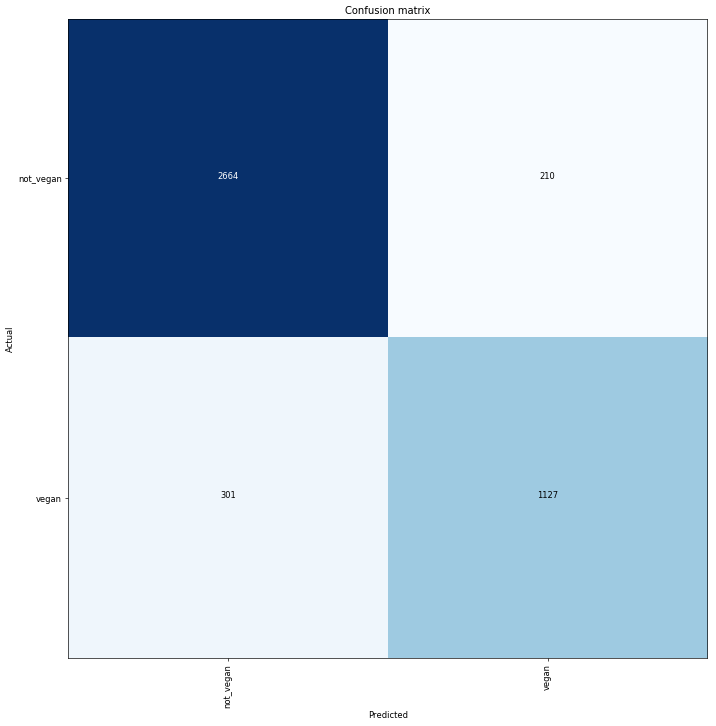

In [32]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Bonus: Frozen (back up)

In [113]:
learn.load('frozen-18epochs');

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

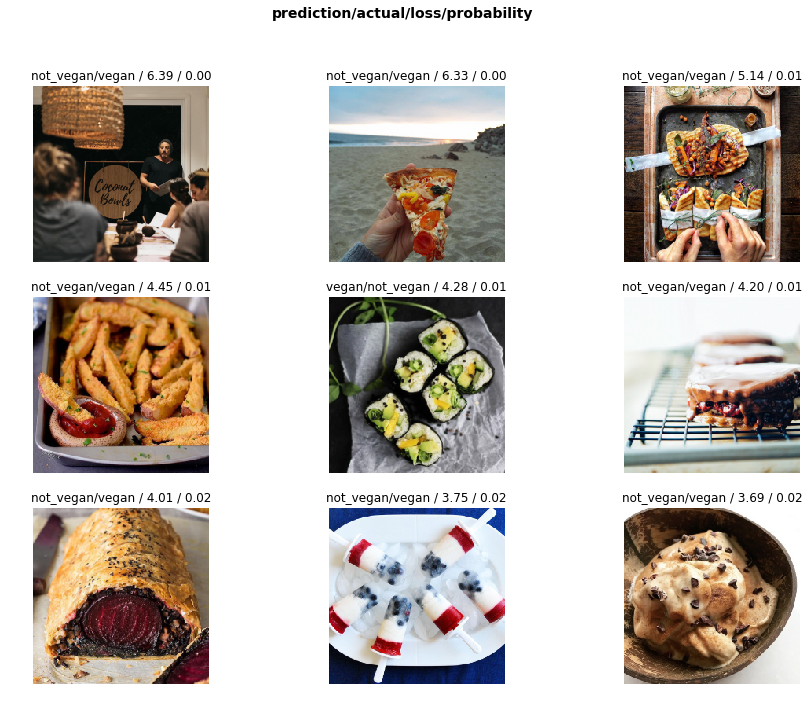

In [20]:
interp.plot_top_losses(9, figsize=(15,11))

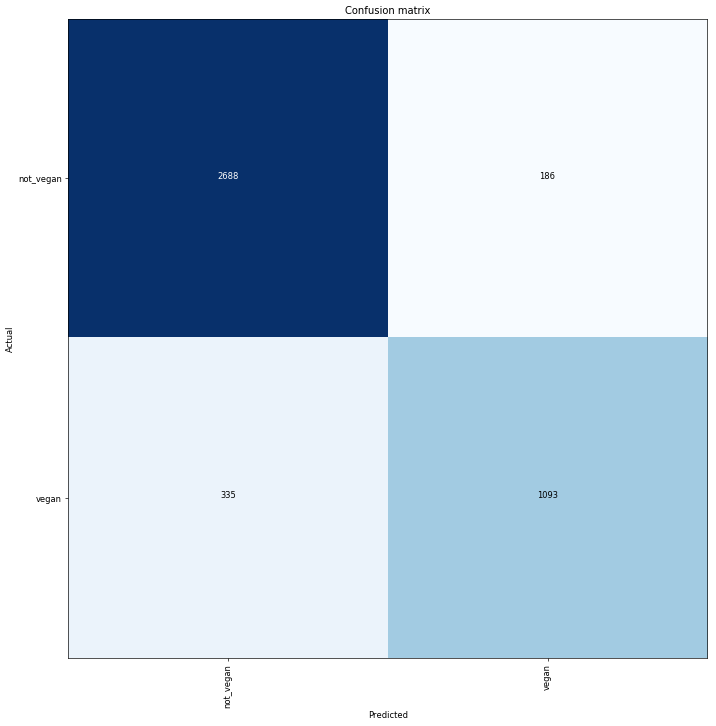

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)